# PPO
原始论文：[Proximal Policy Optimization Algorithms](https://arxiv.org/abs/1707.06347)

推荐课程：[cs234 Lecture 6](https://www.youtube.com/watch?v=8PwvNQ5WS-o&list=PLoROMvodv4rN4wG6Nk6sNpTEbuOSosZdX&index=6)

PPO（clip）目标函数
$$\arg \max_{\theta} \mathbb{E}_{s \sim \nu^{\pi_{\theta_k}}} \mathbb{E}_{a \sim \pi_{\theta_k}(\cdot|s)} \left[ \min \left( \frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)} A^{\pi_{\theta_k}}(s,a), \text{clip} \left( \frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}, 1-\epsilon, 1+\epsilon \right) A^{\pi_{\theta_k}}(s,a) \right) \right]$$

其中 $\text{clip}(x, l, r) := \max(\min(x, r), l)$，即把 $x$ 限制在 $[l, r]$ 内。上式中 $\epsilon$ 是一个超参数，表示进行截断（clip）的范围。

- 如果 $A^{\pi_{\theta_k}}(s,a) > 0$，说明这个动作的价值高于平均，最大化这个式子会增大 $\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}$，但不会让其超过 $1+\epsilon$。
- 反之，如果 $A^{\pi_{\theta_k}}(s,a) < 0$，最大化这个式子会减小 $\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}$，但不会让其超过 $1-\epsilon$。

In [1]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils


class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class PPO:
    ''' PPO with clip '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()

        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps,1 + self.eps) * advantage  # 截断
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [2]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

/Users/crazybread/miniconda3/envs/rl/lib/python3.10/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]/var/folders/1b/8dtqs35938jc7s9qlpl800yc0000gn/T/ipykernel_2248/399651024.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 60.01it/s, episode=500, return=200.000]


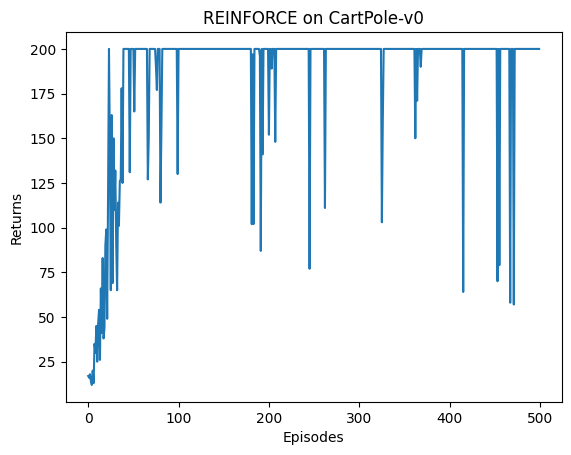

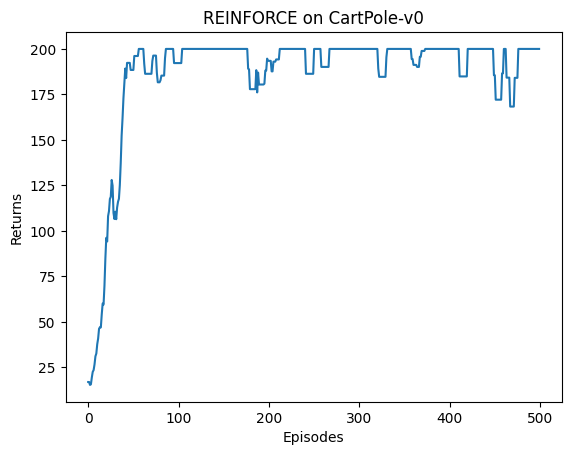

In [3]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

In [4]:
# test agent
def test_agent(agent, n_episodes=10):
    env = gym.make(env_name,render_mode='human')
    returns = []
    for _ in range(n_episodes):
        state, _ = env.reset()
        done = False
        ep_return = 0.0
        while not done:
            action = agent.take_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_return += reward
            state = next_state
        returns.append(ep_return)
        
    env.close()
    return

In [ ]:
test_agent(agent, n_episodes=5)

/Users/crazybread/miniconda3/envs/rl/lib/python3.10/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
/Users/crazybread/miniconda3/envs/rl/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


: 